# COMP47590: Advanced Machine Learning
# Assignment 1: Building Heterogenous Ensembles

- Student 1 Name: Finola Cahill
- Student 1 Number: 07645074

## Import Packages

In [1007]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LinearRegression as LR
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted, check_random_state
from sklearn.utils.multiclass import unique_labels
from sklearn import tree
from sklearn import svm
from sklearn import ensemble
from sklearn import linear_model
from sklearn import neighbors
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.base import is_classifier
from sklearn.utils import resample
from sklearn.base import clone
from sklearn.datasets import load_iris
import itertools
from itertools import chain, combinations
import random
from copy import copy
from scipy import stats
from collections import Counter
import collections
from sklearn.metrics import recall_score
import matplotlib.patches as mpatches
from statistics import mean
import warnings
warnings.filterwarnings('ignore')

## Task 1: The Heterogenous Ensemble Classifier

### Define HeterogenousEnsembleClassifier

In [967]:
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class HeterogenousEnsembleClassifier(BaseEstimator, ClassifierMixin):
    
    """An ensemble classifier that uses heterogeneous models at the base layer. Base models are different due to different hyper-parameters used.

    Parameters
    ----------
    base_estimator: scikit-learn estimator 
        The model type to be used at the base layer of the ensemble model.

    hp_range_map: dictionary
        A dictinary of hyperparamters and the ranges of values that will be used from them
        
    n_estimators: int
        How many models to use in the ensemble
        
    bootstrap: boolean
        Wheter or not to use bootstrap sampling when training base estimators
    
    Attributes
    ----------
    classes_ : array of shape = [n_classes] 
        The classes labels.


    Notes
    -----
    The default values for most base learners are used, unless hyperparameter ranges are specified

    See also
    --------
    

    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> clf = HeterogenousEnsembleClassifier(tree.DecisionTreeClassifier(), {'max_depth':[5, 10, 15], })
    >>> iris = load_iris()
    >>> cross_val_score(clf, iris.data, iris.target, cv=10)

    """
    # Constructor for the classifier object
    def __init__(self, base_estimator = svm.SVC(), n_estimators = 10, hp_range_map = None, bootstrap = True, random_state=None, verbosity = 0):

        """Setup a SuperLearner classifier .
        Parameters
        ----------
        base_estimator: The model type to be used at the base layer of the ensemble model.
        hp_range_map: A dictinary of hyperparamters and the ranges of values that will be used from them
        n_estimators: How many models to use in the ensemble
        bootstrap: Wheter or not to use bootstrap sampling when training base estimators
        
        Returns
        -------
        The estimator
        """     

        # Initialise ranomd state if set
        self.random_state = random_state
        
        # Initialise class variabels
        self.base_estimator = base_estimator
        self.hp_range_map = hp_range_map
        self.n_estimators = n_estimators
        self.bootstrap = bootstrap
        self.verbosity = verbosity
        
    
    def validate_parameters(self):
        if self.n_estimators < 1:
             raise ValueError("n_estimators must be >= 1")
        if is_classifier(self.base_estimator) is False:
            raise ValueError("base_estimator must be a classifier")
        if self.verbosity not in range(0,3):
            raise ValueError("verbosity has three levels, from 0-2")
        if self.hp_range_map is None:
            self.hp_range_map = {}          

    # The fit function to train a classifier
    def fit(self, X, y):
        
        self.validate_parameters()
        
        def checkBootstrap(X, y):
            if self.bootstrap is True:
                return resample(X,y, replace=True)
            return X,y 
                
        def checkValue(value):
            if type(value) is np.ndarray:
                value = value.tolist()
            elif type(value) is not list:
                value = [value]
            return value + [None]
        
        def generate_param_combinations():
            params = []
            for key, value in self.hp_range_map.items():
                params.append(checkValue(value))
                self.keys_.append(key)
            product = itertools.product(*params)
            self.params_ = [ [ p for p in params ] for params in product ]
            if self.verbosity == 2:
                print("{} number of parameter combinations generated for hyperparameter range {}.".format(len(self.params), self.hp_range_map))
        
        
        def extract_params(n):
            params = {}
            for i,key in enumerate(self.keys_):
                if self.params_[n][i] is not None:
                    params[key] = self.params_[n][i]
            return params
    
        def fit_models(X, y):
            for i in range(0, self.n_estimators):
                X_train, y_train = checkBootstrap(X, y)
                params = extract_params(random.randint(0, (len(self.params_)-1)))
                clf = copy(self.base_estimator).set_params(**params)
                if self.verbosity == 2:
                    print("Fitting model {} with parameters: {}".format(i+1, params))
                self.models_.append(clf.fit(X_train, y_train))
            if self.verbosity > 0:
                print("{} models fitted with base estimator {}.".format(i+1, self.base_estimator.__class__.__name__))
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        
        random.seed(self.random_state)
        
        self.params_, self.keys_, self.models_ = [], [], []
        
       #  Count the number of occurrences of each class in the target vector (uses mupy unique function that returns a list of unique values and their counts)
        self.classes_ = np.unique(y)
        
        generate_param_combinations()
        
        fit_models(X,y)
    
        return self

#     # The predict function to make a set of predictions for a set of query instances
    def ensemble_predict(self, X):
        for i, model in enumerate(self.models_):
            self.ensemble_predictions_.append(np.array(model.predict(X)))
            if self.verbosity == 2:
                print('Model no. {} {} predict completed.'.format(i+1, model))
        if self.verbosity == 1:
            print("Predict completed for {} models ".format(i+1))
        self.ensemble_predictions_ = np.asarray(self.ensemble_predictions_)
    
    def predict(self, X):
        
        self.ensemble_predictions_ = []
                
        def select_most_frequent(row, query_number):
            freq, maxi = {}, 0
            prediction, count = np.unique(row, return_counts=True)
            for i,v in enumerate(count):
                freq[v] = freq.get(v, []) + [prediction[i]]
                maxi = max(maxi, v)
            return get_mode(freq,maxi, query_number)
        
        def interpret_predictions():
            if self.verbosity == 2:
                print("Aggregating ensemble predictions.")
            final_prediction = []
            for i,row in enumerate(self.ensemble_predictions_.transpose()):
                final_prediction += select_most_frequent(row, i)
            if self.verbosity == 1:
                print("Results aggregated for {} queries".format(i+1))
            return final_prediction
    
        def get_mode(frequency, maxi, i):
            if len(frequency[maxi]) > 1:
                if self.verbosity == 2:
                    print("Multiple maximums for query {}, will select at random from {}".
                         format(i+1, frequency[maxi]))
                return [frequency[maxi][(random.randint(0, (len(frequency[maxi])-1)))]]
            return frequency[maxi]
    
        check_is_fitted(self, ['models_'])
        
        # Check that the input features match the type and shape of the training features
        X = check_array(X)
    
     #   self.ensemble_predictions_ = np.array([model.predict(X) for model in self.models])
        self.ensemble_predict(X)
        
        return np.array(interpret_predictions())

    #     # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        
        self.probs_, self.ensemble_predictions_ = [], []

        def calculate_probabilities():
            if self.verbosity > 0:
                print("Calculating probabilities from ensemble predictions")
            for p in self.ensemble_predictions_.transpose():
                key, val = np.unique(p, return_counts=True)
                counts = dict(zip(key, val))
                self.probs_.append([(counts[c] / len(p)) if c in counts else 0.0 for c in self.classes_])
            if self.verbosity > 0:
                print("Probabilities calculated for {} queries and {} classes".format(len(self.probs_), len(self.classes_)))
        
        check_is_fitted(self, ['models_'])
        
        X = check_array(X)   
        
        self.ensemble_predict(X)
        
        calculate_probabilities()
        
        return np.array(self.probs_)

### Test the HeterogenousEnsembleClassifier

In [968]:
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
iris = load_iris()
clf = HeterogenousEnsembleClassifier(n_estimators=40, verbosity = 1)
clf.fit(iris.data, iris.target)
# clf.predict(iris.data)
clf.predict_proba(iris.data)
# print(x.shape)

40 models fitted with base estimator SVC.
Predict completed for 40 models 
Calculating probabilities from ensemble predictions
Probabilities calculated for 150 queries and 3 classes


array([[1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.

Perform a simple test using the HeterogenousEnsembleClassifier on the Iris dataset

In [859]:
iris = load_iris()
base_estimator = svm.SVC()
hyperparam_range = {"kernel":["rbf", "linear"], "C":np.arange(0.1, 1.0, 10), "gamma":[0.1, 0.5], "probability":[True]}
n_estimators = 10
clf = HeterogenousEnsembleClassifier(base_estimator, n_estimators, hyperparam_range, verbosity = 2)
clf.fit(iris.data, iris.target)
y_pred = clf.predict(iris.data)
print(metrics.classification_report(iris.target, y_pred))
print("Confusion Matrix")
display(pd.crosstab(np.array(iris.target), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
y_pred = clf.predict_proba(iris.data)
y_pred2 = clf.predict(iris.data)


36 number of parameter combinations generated for hyperparameter range {'kernel': ['rbf', 'linear'], 'C': array([0.1]), 'gamma': [0.1, 0.5], 'probability': [True]}.
Fitting model 1 with parameters: {'probability': True}
Fitting model 2 with parameters: {'C': 0.1, 'gamma': 0.5, 'probability': True}
Fitting model 3 with parameters: {'probability': True}
Fitting model 4 with parameters: {'kernel': 'rbf', 'gamma': 0.5}
Fitting model 5 with parameters: {'kernel': 'rbf', 'C': 0.1, 'probability': True}
Fitting model 6 with parameters: {'kernel': 'linear', 'C': 0.1}
Fitting model 7 with parameters: {'kernel': 'linear', 'gamma': 0.1, 'probability': True}
Fitting model 8 with parameters: {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.5, 'probability': True}
Fitting model 9 with parameters: {'C': 0.1, 'gamma': 0.5, 'probability': True}
Fitting model 10 with parameters: {'kernel': 'linear'}
10 models fitted with base estimator SVC.
Model no. 1 SVC(probability=True) predict completed.
Model no. 2 SVC(C=0.1

Predicted,0,1,2,All
True,,,,
0,50,0,0,50
1,0,48,2,50
2,0,1,49,50
All,50,49,51,150


Model no. 1 SVC(probability=True) predict completed.
Model no. 2 SVC(C=0.1, gamma=0.5, probability=True) predict completed.
Model no. 3 SVC(probability=True) predict completed.
Model no. 4 SVC(gamma=0.5) predict completed.
Model no. 5 SVC(C=0.1, probability=True) predict completed.
Model no. 6 SVC(C=0.1, kernel='linear') predict completed.
Model no. 7 SVC(gamma=0.1, kernel='linear', probability=True) predict completed.
Model no. 8 SVC(C=0.1, gamma=0.5, probability=True) predict completed.
Model no. 9 SVC(C=0.1, gamma=0.5, probability=True) predict completed.
Model no. 10 SVC(kernel='linear') predict completed.
Calculating probabilities from ensemble predictions
Probabilities calculated for 150 queries and 3 classes
Model no. 1 SVC(probability=True) predict completed.
Model no. 2 SVC(C=0.1, gamma=0.5, probability=True) predict completed.
Model no. 3 SVC(probability=True) predict completed.
Model no. 4 SVC(gamma=0.5) predict completed.
Model no. 5 SVC(C=0.1, probability=True) predict com

Perform a cross validation experiment

In [860]:
scores = cross_val_score(clf, iris.data, iris.target, cv=10)
print(scores)
print(np.mean(scores), " +/- ", np.std(scores))

36 number of parameter combinations generated for hyperparameter range {'kernel': ['rbf', 'linear'], 'C': array([0.1]), 'gamma': [0.1, 0.5], 'probability': [True]}.
Fitting model 1 with parameters: {'C': 0.1, 'probability': True}
Fitting model 2 with parameters: {'kernel': 'linear', 'gamma': 0.1, 'probability': True}
Fitting model 3 with parameters: {'kernel': 'linear', 'C': 0.1, 'probability': True}
Fitting model 4 with parameters: {'gamma': 0.1}
Fitting model 5 with parameters: {}
Fitting model 6 with parameters: {'C': 0.1, 'probability': True}
Fitting model 7 with parameters: {'kernel': 'linear', 'gamma': 0.1, 'probability': True}
Fitting model 8 with parameters: {'C': 0.1, 'gamma': 0.1, 'probability': True}
Fitting model 9 with parameters: {'kernel': 'linear', 'gamma': 0.1}
Fitting model 10 with parameters: {'kernel': 'linear', 'C': 0.1, 'gamma': 0.1, 'probability': True}
10 models fitted with base estimator SVC.
Model no. 1 SVC(C=0.1, probability=True) predict completed.
Model no.

Fitting model 3 with parameters: {'C': 0.1, 'probability': True}
Fitting model 4 with parameters: {'C': 0.1, 'gamma': 0.5, 'probability': True}
Fitting model 5 with parameters: {'gamma': 0.5}
Fitting model 6 with parameters: {'kernel': 'linear', 'gamma': 0.1, 'probability': True}
Fitting model 7 with parameters: {'C': 0.1, 'probability': True}
Fitting model 8 with parameters: {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.1}
Fitting model 9 with parameters: {'C': 0.1}
Fitting model 10 with parameters: {}
10 models fitted with base estimator SVC.
Model no. 1 SVC(C=0.1, gamma=0.5, probability=True) predict completed.
Model no. 2 SVC(C=0.1) predict completed.
Model no. 3 SVC(C=0.1, probability=True) predict completed.
Model no. 4 SVC(C=0.1, gamma=0.5, probability=True) predict completed.
Model no. 5 SVC(gamma=0.5) predict completed.
Model no. 6 SVC(gamma=0.1, kernel='linear', probability=True) predict completed.
Model no. 7 SVC(C=0.1, probability=True) predict completed.
Model no. 8 SVC(C=0.1, ga

## Test with imbalanced, non numeric targest

In [861]:
surv = pd.read_csv('survival.csv')
surv['Survived'] = 'GE5'
surv.loc[surv['Class']==2,'Survived']='L5'
surv.head()


,Age,Year,NNodes,Class,Survived
0,30,64,1,1,GE5
1,30,62,3,1,GE5
2,30,65,0,1,GE5
3,31,59,2,1,GE5
4,31,65,4,1,GE5


In [862]:
y = surv.pop('Survived').values
surv.pop('Class')
X = surv.values
X.shape, y.shape

((306, 3), (306,))

In [863]:
base_estimator = svm.SVC()
hyperparam_range = {"kernel":["rbf", "linear"], "C":np.arange(0.1, 1.0, 10), "gamma":[0.1, 0.5], "probability":[True]}
n_estimators = 10
clf = HeterogenousEnsembleClassifier(base_estimator, n_estimators, hyperparam_range, verbosity = 1)
clf.fit(X, y)
y_pred = clf.predict(X)
display(pd.crosstab(y, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
print(metrics.classification_report(y, y_pred))


10 models fitted with base estimator SVC.
Predict completed for 10 models 
Results aggregated for 306 queries


Predicted,GE5,All
True,,
GE5,225,225
L5,81,81
All,306,306


              precision    recall  f1-score   support

         GE5       0.74      1.00      0.85       225
          L5       0.00      0.00      0.00        81

    accuracy                           0.74       306
   macro avg       0.37      0.50      0.42       306
weighted avg       0.54      0.74      0.62       306



In [864]:
iris.data.shape

(150, 4)

In [865]:
iris.target.shape

(150,)

## Task 2: The StackedHeterogenousEnsembleClassifier Class

### Define StackedHeterogenousEnsembleClassifier Class

In [894]:
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class StackedHeterogenousEnsembleClassifier(BaseEstimator, ClassifierMixin):
    
    """An ensemble classifier that uses heterogeneous models at the base layer. Base models are different due to different hyper-parameters used. Aggrefgattion is perfomred using a stack layer model.

    Parameters
    ----------
    base_estimator: scikit-learn estimator 
        The model type to be used at the base layer of the ensemble model.

    hp_range_map: dictionary
        A dictinary of hyperparamters and the ranges of values that will be used from them
        
    n_estimators: int
        How many models to use in the ensemble
        
    bootstrap: boolean
        Whether or not to use bootstrap sampling wehn training base estimators
    
    stack_layer_estimator: scikit-learn estimator 
        Estimator type of the stack  layer model
        
    base_stack_data_ratio: float
        The ratio with which to split the data for straing the base and stack layers.
        
    Attributes
    ----------
    classes_ : array of shape = [n_classes] 
        The classes labels.

    Notes
    -----
    The default values for most base learners are used, unless hyperparameter ranges are specified

    See also
    --------
    

    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> clf = StackedHeterogenousEnsembleClassifier(tree.DecisionTreeClassifier(), {'max_depth':[5, 10, 15], })
    >>> iris = load_iris()
    >>> cross_val_score(clf, iris.data, iris.target, cv=10)

    """
    # Constructor for the classifier object
    def __init__(self, base_estimator = svm.SVC(), n_estimators = 10, hp_range_map = None, bootstrap = True, stack_layer_estimator = svm.SVC(), base_stack_data_ratio = 0.7, random_state=None, verbosity = 0):

        """Setup a StackedHeterogenousEnsembleClassifier classifier .
        Parameters
        ----------
        base_estimator: The model type to be used at the base layer of the ensemble model.
        hp_range_map: A dictinary of hyperparamters and the ranges of values that will be used from them
        n_estimators: How many models to use in the ensemble
        bootstrap: Wheter or not to use bootstrap sampling wehn training base estimators
        stack_layer_estimator: Estimator type of the stack  layer model
        base_stack_data_ratio: The ratio with which to split the data for straing the base and stack layers.
        
        Returns
        -------
        The estimator
        """     

        # Initialise ranomd state if set
        self.random_state = random_state
        
        # Initialise class variabels
        self.base_estimator = base_estimator
        self.hp_range_map = hp_range_map
        self.n_estimators = n_estimators
        self.bootstrap = bootstrap
        self.stack_layer_estimator = stack_layer_estimator
        self.base_stack_data_ratio = base_stack_data_ratio
        self.verbosity = verbosity
        
        
    
    def validate_parameters(self):
        if self.n_estimators < 1:
             raise ValueError("n_estimators must be >= 1")
        if is_classifier(self.base_estimator) is False:
            raise ValueError("base_estimator must be a classifier")
        if is_classifier(self.stack_layer_estimator) is False:
            raise ValueError("stack_layer_estimator must be a classifier")
        if self.verbosity not in range(0,3):
            raise ValueError("verbosity has range 0-2")
        if self.base_stack_data_ratio <= 0 or self.base_stack_data_ratio >= 1:
            raise ValueError("base_stack_data_ratio must be greater than 0 and smaler than 1.")
        if self.hp_range_map is None:
            self.hp_range_map = {}

    # The fit function to train a classifier
    def fit(self, X, y):

        self.validate_parameters()
    
        def checkBootstrap(X, y):
            if self.bootstrap is True:
                return resample(X,y, replace=True)
            return X,y 
        
        def checkValue(value):
            if type(value) is np.ndarray:
                value = value.tolist()
            elif type(value) is not list:
                value = [value]
            return value + [None]
    
        def generate_param_combinations():
            params = []
            for key, value in self.hp_range_map.items():
                params.append(checkValue(value))
                self.keys.append(key)
            product = itertools.product(*params)
            self.params = [ [ p for p in params ] for params in product ] 
            if self.verbosity == 2:
                print("{} number of parameter combinations generated for hyperparameter range {}.".format(len(self.params), self.hp_range_map))
        
        def extract_params(n):
            params = {}
            for i,key in enumerate(self.keys):
                if self.params[n][i] is not None:
                    params[key] = self.params[n][i]
            return params
    
        def fit_ensemble(X_train, X_valid, y_train):
            for i in range(0, self.n_estimators):
                X_train, y_train = checkBootstrap(X_train, y_train)
                params = extract_params(random.randint(0, (len(self.params)-1)))
                clf = copy(self.base_estimator).set_params(**params)
                if self.verbosity == 2:
                    print("Fitting model {} with parameters: {}".format(i+1, params))
                clf.fit(X_train, y_train)
                self.models.append(clf)
                self.model_output.append(clf.predict(X_valid))
            self.model_output = np.asarray(self.model_output)
            if self.verbosity > 0:
                print("{} models fitted with base estimator {}.".format(i+1, self.base_estimator.__class__.__name__))
        
        def prepare_stack_training_set():
            
            self.model_output = [to_categorical(m, num_classes=len(self.classes_)+1) for m in self.model_output.transpose()]
    
            self.model_output = np.asarray(self.model_output)
    
            self.model_output = self.model_output.reshape(X_valid.shape[0], self.n_estimators*(len(self.classes_)+1))
        
            if self.verbosity > 0:
                print("Training set of size {} prepared for stack layer".format(self.model_output.size))
            
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=self.base_stack_data_ratio,
                                                              random_state=self.random_state)
        if self.verbosity > 0:
            print("X_train of size {} split at {} ratio". format(X.size, self.base_stack_data_ratio))
        
        if self.verbosity == 2:
            print("X_train for ensemble now size {}, X_train for stack now size {}".format(X_train.size, X_valid.size))
        
        random.seed(self.random_state)
        
        self.params, self.keys, self.models, self.model_output = [], [], [], []
                
       #  Count the number of occurrences of each class in the target vector (uses mupy unique function that returns a list of unique values and their counts)
        self.classes_ = np.unique(y)

        generate_param_combinations()
        
        fit_ensemble(X_train, X_valid, y_train)
    
        prepare_stack_training_set()        
        
        self.stack_layer_estimator.fit(self.model_output, y_valid)
        
        if self.verbosity > 0:
            print("Stack layer with base estimator {} has been fit".format(self.stack_layer_estimator.__class__.__name__))
        
        return self
    
    def ensemble_predict(self, X):
        for i, model in enumerate(self.models):
            self.model_output.append(model.predict(X))
            if self.verbosity == 2:
                print('Model no. {} {} predict completed.'.format(i+1, model))
        if self.verbosity > 0:
            print("Predict completed for {} models ".format(i+1))
        self.model_output = np.asarray(self.model_output)  

        
    def prepare_data_for_stack(self, X):
        
        if self.verbosity > 0:
            print("Preparing data for stack layer.")
            
        for i, prediction in enumerate(self.model_output.transpose()):
            self.ensemble_predictions_.append(to_categorical(prediction, num_classes=len(self.classes_)+1))
        
        self.ensemble_predictions_ = np.array(self.ensemble_predictions_)
        
        self.ensemble_predictions_ = self.ensemble_predictions_.reshape(X.shape[0], (len(self.classes_)+1) * self.n_estimators)

        if self.verbosity > 0:
                print("Data set of size {} prepared for stack layer".format(self.model_output.size))
        #     
# The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        
        check_is_fitted(self, ['models'])
        
        self.ensemble_predictions_, self.model_output = [], []
        
        # Check that the input features match the type and shape of the training features
        X = check_array(X)
    
        self.ensemble_predict(X)
        
        self.prepare_data_for_stack(X)
        
        if self.verbosity == 2:
            print("Stack layer with base_estimator {} making prediction".format(self.stack_layer_estimator.__class__.__name__))
        
        return self.stack_layer_estimator.predict(self.ensemble_predictions_)

    
#     # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        
        check_is_fitted(self, ['models'])
        
        self.model_output, self.ensemble_predictions_ = [], []

        # Check that the input features match the type and shape of the training features
        X = check_array(X)

        self.ensemble_predict(X)
        
        self.prepare_data_for_stack(X)
        
        if self.verbosity == 2:
            print("Stack layer with base_estimator {} making prediction".format(self.stack_layer_estimator.__class__.__name__))
       
        return(self.stack_layer_estimator.predict_proba(self.ensemble_predictions_))
        

In [895]:
iris = load_iris()
n_estimators = 10
base_estimator = svm.SVC()
hyperparam_range = {"kernel":["rbf", "linear"], "C":np.arange(0.1, 1.0, 0.1), "gamma":[0.1, 0.5], "probability":[True]}
# hyperparam_range = None
clf = StackedHeterogenousEnsembleClassifier(base_estimator, n_estimators, hyperparam_range, True, svm.SVC(probability=True), 0.7, verbosity = 0)
clf.fit(iris.data, iris.target)
clf.predict(iris.data)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

### Test the StackedHeterogenousEnsembleClassifier

In [896]:
clf.predict_proba(iris.data)

array([[0.91301486, 0.03210567, 0.05487947],
       [0.91301486, 0.03210567, 0.05487947],
       [0.91301486, 0.03210567, 0.05487947],
       [0.91301486, 0.03210567, 0.05487947],
       [0.91301486, 0.03210567, 0.05487947],
       [0.91301486, 0.03210567, 0.05487947],
       [0.91301486, 0.03210567, 0.05487947],
       [0.91301486, 0.03210567, 0.05487947],
       [0.91301486, 0.03210567, 0.05487947],
       [0.91301486, 0.03210567, 0.05487947],
       [0.91301486, 0.03210567, 0.05487947],
       [0.91301486, 0.03210567, 0.05487947],
       [0.91301486, 0.03210567, 0.05487947],
       [0.91301486, 0.03210567, 0.05487947],
       [0.91301486, 0.03210567, 0.05487947],
       [0.91301486, 0.03210567, 0.05487947],
       [0.91301486, 0.03210567, 0.05487947],
       [0.91301486, 0.03210567, 0.05487947],
       [0.91301486, 0.03210567, 0.05487947],
       [0.91301486, 0.03210567, 0.05487947],
       [0.91301486, 0.03210567, 0.05487947],
       [0.91301486, 0.03210567, 0.05487947],
       [0.

Perform a simple test using the StackedHeterogenousEnsembleClassifier on the Iris dataset

In [662]:
iris = load_iris()
n_estimators = 10
base_estimator = svm.SVC()
hyperparam_range = {"kernel":["rbf", "linear"], "C":np.arange(0.1, 1.0, 0.1), "gamma":[0.1, 0.5], "probability":[True]}
clf = StackedHeterogenousEnsembleClassifier(base_estimator, n_estimators, hyperparam_range, True, svm.SVC(probability=True), 0.7, verbosity = 1)
clf.fit(iris.data, iris.target)
y_pred = clf.predict(iris.data)
print(metrics.classification_report(iris.target, y_pred))
print("Confusion Matrix")
display(pd.crosstab(np.array(iris.target), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
y_pred = clf.predict_proba(iris.data)
y_pred[0:10]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.94      0.96      0.95        50
           2       0.96      0.94      0.95        50

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150

Confusion Matrix


Predicted,0,1,2,All
True,,,,
0,50,0,0,50
1,0,48,2,50
2,0,3,47,50
All,50,51,49,150


(150, 40)


array([[0.89444764, 0.05925779, 0.04629457],
       [0.89444764, 0.05925779, 0.04629457],
       [0.89444764, 0.05925779, 0.04629457],
       [0.89444764, 0.05925779, 0.04629457],
       [0.89444764, 0.05925779, 0.04629457],
       [0.89444764, 0.05925779, 0.04629457],
       [0.89444764, 0.05925779, 0.04629457],
       [0.89444764, 0.05925779, 0.04629457],
       [0.89444764, 0.05925779, 0.04629457],
       [0.89444764, 0.05925779, 0.04629457]])

Perform a cross validation experiment

In [898]:
scores = cross_val_score(clf, iris.data, iris.target, cv=10)
print(scores)
print(np.mean(scores), " +/- ", np.std(scores))

[1.         0.93333333 1.         1.         1.         0.8
 0.93333333 0.93333333 1.         1.        ]
0.9600000000000002  +/-  0.06110100926607785


## Task 3: Compare the Performance of the Different Ensembles Defined

### Load Experiment Dataset

Take only a sample of the dataset for fast testing

In [899]:
data_sampling_rate = .2

Load the dataset and explore it.

In [900]:
dataset = pd.read_csv('Sensorless_drive_diagnosis.csv')
dataset = dataset.sample(frac=data_sampling_rate) #take a sample from the dataset so everyhting runs smoothly
display(dataset.head())

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F40,F41,F42,F43,F44,F45,F46,F47,F48,label
20953,-2.570000e-06,2.470000e-05,-0.000120,-0.000015,-0.000034,-0.000412,0.029154,0.029129,0.029250,0.046155,...,-0.51370,2.9401,6.6339,-1.5032,-1.5032,-1.5031,-1.4923,-1.4924,-1.4926,4
16336,8.480000e-07,2.270000e-08,-0.000003,0.000001,-0.000005,0.000006,-0.005013,-0.005013,-0.005010,0.018420,...,-0.65224,3.5418,3.0023,-1.4975,-1.4975,-1.4975,-1.4970,-1.4970,-1.4970,4
7105,-3.710000e-06,1.120000e-05,0.000058,-0.000004,-0.000014,-0.000221,-0.014398,-0.014409,-0.014467,-0.023750,...,-0.79558,7.6029,7.0863,-1.5019,-1.5019,-1.5019,-1.4955,-1.4955,-1.4956,2
42654,2.840000e-06,2.630000e-06,-0.000012,0.000003,-0.000004,-0.000003,0.001017,0.001015,0.001026,-0.046681,...,-0.61254,14.4430,2.6726,-1.4981,-1.4981,-1.4982,-1.4955,-1.4955,-1.4955,9
10719,-2.970000e-06,3.820000e-06,0.000007,-0.000002,0.000009,-0.000003,0.014429,0.014425,0.014418,0.016423,...,-0.53736,7.4193,6.8782,-1.5005,-1.5005,-1.5005,-1.4990,-1.4990,-1.4990,3


In [901]:
print("Missing Values")
print(sum(dataset.isnull().sum()))

Missing Values
0


In [902]:
y = dataset.pop('label')
X = dataset
y.value_counts()/len(y)


10    0.095026
9     0.094856
3     0.092976
11    0.092036
5     0.091010
2     0.090583
8     0.089472
7     0.089386
6     0.089386
1     0.089301
4     0.085968
Name: label, dtype: float64

In [ ]:
X_train, X_test, y_train, y_test \
    = train_test_split(X, y, \
                       shuffle=True, \
                       stratify = y, \
                       train_size = 0.7)

X_train, X_valid, y_train, y_valid \
    = train_test_split(X_train, y_train, \
                        shuffle=True, \
                        stratify = y_train, \
                        train_size = 0.5/0.7)
print(X_train.shape, X_test.shape, X_valid.shape)

In [904]:
# Make the min max scalar object
min_max_scaler = preprocessing.MinMaxScaler((-1,1))
min_max_scaler.fit(X_train)

# Train the scalar on the training dataset
a = min_max_scaler.transform(X_train)

# Little trick to stop transform from pandas daataframe to numpy array losing column namesWatch out for putting back in columns here
cols = X_train.columns
X_train = pd.DataFrame(a, columns = cols) 

# Also normalise other partitions
a = min_max_scaler.transform(X_train_plus_valid)
X_train_plus_valid = pd.DataFrame(a, columns = cols) 
a = min_max_scaler.transform(X_valid)
X_valid = pd.DataFrame(a, columns = cols) 
a = min_max_scaler.transform(X_test)
X_test = pd.DataFrame(a, columns = cols) 


In order to develop an initial performance baseline , I decided to compare the performance of the Heterogeneous Ensemble against itself, given four different base classifiers. 
- I decided to use Decision Trees ars they often work well in ensembles. - I then selected kNN as it often does not perform well in ensembles, due to its' stability, and though it would be interesting to see if it performed better with a Heterogeneous Ensemble. 
- SVM is the default classifier given, and hence worth considering in testing. It is also already an ensemble, so it will be interesting to see if the additional diversity produced by the sampling of the hyper paramter space has a significant impact.  
- Finally, I decided to use a logistic regressor, as I have not seen logistic regression frequently used in ensembles, and I was curious as to its' performance. 

In [905]:
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from collections import Counter
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.ensemble import BaggingClassifier

In [1071]:
models = {}
models['DTree'] = DecisionTreeClassifier(random_state=42)
models['kNN'] = KNeighborsClassifier()  
models['SVM'] = svm.SVC(random_state=42)
models['LR'] = LogisticRegression(random_state=42)


In [1005]:
##11 hyper parameters each 

In [1072]:
hparams = {}
hparams['DTree'] = {'max_depth': list(range(2,100)), 'min_samples_split': list(range(2,50))}
hparams['kNN'] = {'n_neighbors': list(range(3,50)), 'metric': ['euclidean', 'chebyshev', 'minkowski', 'manhattan']}
hparams['SVM'] = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': np.arange(0.1, 10, .1).tolist()}
hparams['LR'] = {'C': np.arange(1.0, 10.0, 0.5).tolist(), 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

For this initial test we will be comparing the performance of the ensemble of each classifier against the single classifier itself, and also against a bagged version of the classifier. As an initial measure of performance, we will be looking at the accuracy score when using the valdation set. The parameter ranges have been hand-selected with the goal of provoking the most diversity possible for the heterogenous ensemble. For this initial test, n will be left at the deafult, 10, for both the bootstrapped ensemble and the heterogeneous ensemble. For both the bootstrapped classifier, the default parameters will be used. 

In [935]:
benchmark_1 = pd.DataFrame(columns=[m for m in hparams.keys()],
                            index = ['Single', 'Bootstrapped', 'Ensemble', 'Stacked Ensemble'])
benchmark_2 = pd.DataFrame(columns=[m for m in hparams.keys()],
                            index = ['Single', 'Bootstrapped', 'Ensemble', 'Stacked Ensemble'])
for m in models:
    clfs = [copy(models[m]),BaggingClassifier(base_estimator=copy(models[m]), random_state=42),
           HeterogenousEnsembleClassifier(base_estimator=copy(models[m]), hp_range_map=hparams[m],random_state=42),
           StackedHeterogenousEnsembleClassifier(base_estimator=copy(models[m]), hp_range_map=hparams[m],random_state=42)]
    pred = []
    f1 = []
    for c in clfs:
        clf = c
        y_preds = clf.fit(X_train, y_train).predict(X_valid)
        pred.append(accuracy_score(y_valid, y_preds))
        f1.append(f1_score(y_valid, y_preds, average='macro'))
    benchmark_1[m] = pred
    benchmark_2[m] = f1

In [936]:
ranked_benchmark = benchmark_1.copy().rank(ascending=False)
ranked_benchmark['average'] = ranked_benchmark.mean(axis=1).rank()


In [937]:
ranked_benchmark

,DTree,kNN,SVM,LR,average
Single,3.0,2.0,3.0,4.0,4.0
Bootstrapped,1.0,3.5,4.0,3.0,3.0
Ensemble,2.0,3.5,1.0,1.0,1.0
Stacked Ensemble,4.0,1.0,2.0,2.0,2.0


Above, we can see that the bootstrapped clasifiers and the heterogeneous ensemble seem to be perfoming best in terms of the rankings. These rankings do not give us a view on the actual range of performance with regards to accuracy. Below I will plot he accuracy scores to give us a clearer view of their performance. 

In [938]:
benchmark_1

,DTree,kNN,SVM,LR
Single,0.945323,0.928663,0.845792,0.863733
Bootstrapped,0.967962,0.926527,0.841094,0.866724
Ensemble,0.960273,0.926527,0.905596,0.883383
Stacked Ensemble,0.942760,0.937206,0.894490,0.869714


In [939]:
ranked_benchmark2 = benchmark_2.copy().rank(ascending=False)
ranked_benchmark2['average'] = ranked_benchmark2.mean(axis=1).rank()
ranked_benchmark2

,DTree,kNN,SVM,LR,average
Single,3.0,2.0,3.0,4.0,4.0
Bootstrapped,1.0,3.0,4.0,3.0,3.0
Ensemble,2.0,4.0,1.0,1.0,1.0
Stacked Ensemble,4.0,1.0,2.0,2.0,2.0


We can see here that the rankings for the F1 score of the models are identical to the accuracy rankings. Given that the data is relatively balanced, this makes sense, the models are behaving in a fairly unbiased mannor. 

In [700]:
def plot_subplot(fig, ax, title, res):
    X = np.arange(1)
    ax.axhline(y=res.iloc[0], color='black')
    ax.bar(X + 0.00, res.iloc[0], color = 'b', alpha=0.5, width = 0.05, label="Single")
    ax.bar(X + 0.10, res.iloc[1], color = 'y', alpha=0.5, width = 0.05, label = "Bootstrapped")
    ax.bar(X + 0.20, res.iloc[2], color = 'g', alpha=0.5, width = 0.05, label = "Heterogeneous")
    ax.bar(X + 0.30, res.iloc[3], color = 'r', alpha=0.5, width = 0.05, label = "Heterogeneous")
    ax.set_title(title)


Text(0.5, 0.98, 'Accuracy Scores')

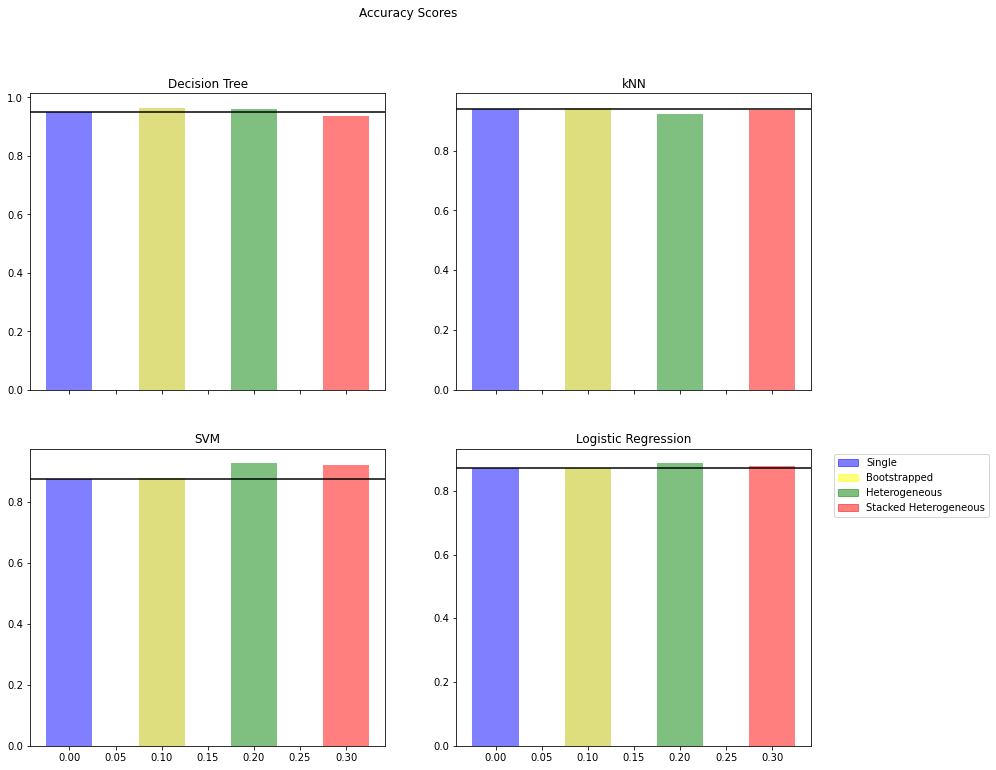

In [701]:
f, axs = plt.subplots(2, 2, figsize=(14,12), sharex=True)
plot_subplot(f, axs[0,0], "Decision Tree", benchmark_1['DTree'])
plot_subplot(f, axs[0,1], "kNN", benchmark_1['kNN'])
plot_subplot(f, axs[1,0], "SVM", benchmark_1['SVM'])
plot_subplot(f, axs[1,1], "Logistic Regression", benchmark_1['LR'])
b = mpatches.Patch(color='blue', alpha=0.5, label='Single')
y = mpatches.Patch(color='yellow', alpha=0.5, label='Bootstrapped')
g = mpatches.Patch(color='green', alpha=0.5, label='Heterogeneous')
r = mpatches.Patch(color='red', alpha=0.5, label='Stacked Heterogeneous')
plt.legend(handles=[b,y,g,r], bbox_to_anchor=(1.05, 1), loc='upper left')
f.suptitle("Accuracy Scores")

- Globally the rankings of performance are very changeable. Although the non-stacked heterogeneous ensemble is first overall in the average rankings, there is no obvious "winner". 
- For the decision tree, the stacked classifier has performed the worst, even worse than the single base classifier. The heterogeneous ensemble has come in second to the boosted classifier. 
- For kNN, the heterogeneous ensemble has perforformed the worst on this data, and the stacked hetereogeneous ensemble has performed the best. This is an interesting result, clearly the stacked classifier has learnt something more sophisticated than predicting the majority in this instance.
- For SVM both the heterogeneous ensemble and the stacked heterogeneous ensemble have performed very well, with the stacked heterogeneous ensemble performing slightly worse than the standard heterogeneous ensemble. 
- And for Logistic Regression we see a similar result, the two heterogeneous ensembles have performed the best, with the non-stacked model performing slightly better than the stacked model.

Given that holdout testing is done with a single "slice" of the data, it hard to discern whether these results are fiable our not. I have decided to take the models where the stacked classifier performed the worst (Decision tree) and the non-stacked classifier performed the worst (kNN) and cross validate, while also varying the random seed, to check the stability of these results. I am leaving the hyper paramater range unchanged.


In [942]:
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

In [991]:
reps = 5
folds = 10
benchmark_3 = pd.DataFrame(index = ['Single', 'Bootstrapped', 'Ensemble', 'Stacked Ensemble'],
                           columns = ['Fold ' + str(i) for i in range(1,reps+1)])
for i in range (0, reps):
    kf = KFold(n_splits = folds, shuffle = True)
    clfs = [DecisionTreeClassifier(random_state =i+i),
            BaggingClassifier(base_estimator=copy(DecisionTreeClassifier(random_state = i+i)), random_state=i+i),
            HeterogenousEnsembleClassifier(base_estimator=DecisionTreeClassifier(random_state =i+i), hp_range_map=hparams['DTree'],random_state=i+i, verbosity=0),
            StackedHeterogenousEnsembleClassifier(base_estimator=DecisionTreeClassifier(random_state =i+i), hp_range_map=hparams['DTree'],random_state=i+i, verbosity=0)]
    results = []
    for c in clfs:
        print("rep ", i+1,"class ", c.__class__.__name__)
        xval = cross_val_score(c, X_train, y_train, cv=kf, scoring='accuracy', error_score="raise")
        results.append(xval.mean())
    benchmark_3['Fold '+str(i+1)] = results
        


rep  1 class  DecisionTreeClassifier
rep  1 class  BaggingClassifier
rep  1 class  HeterogenousEnsembleClassifier
rep  1 class  StackedHeterogenousEnsembleClassifier
rep  2 class  DecisionTreeClassifier
rep  2 class  BaggingClassifier
rep  2 class  HeterogenousEnsembleClassifier
rep  2 class  StackedHeterogenousEnsembleClassifier
rep  3 class  DecisionTreeClassifier
rep  3 class  BaggingClassifier
rep  3 class  HeterogenousEnsembleClassifier
rep  3 class  StackedHeterogenousEnsembleClassifier
rep  4 class  DecisionTreeClassifier
rep  4 class  BaggingClassifier
rep  4 class  HeterogenousEnsembleClassifier
rep  4 class  StackedHeterogenousEnsembleClassifier
rep  5 class  DecisionTreeClassifier
rep  5 class  BaggingClassifier
rep  5 class  HeterogenousEnsembleClassifier
rep  5 class  StackedHeterogenousEnsembleClassifier


In [994]:
benchmark_3

,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
Single,0.944786,0.942222,0.940684,0.938974,0.942051
Bootstrapped,0.967009,0.962906,0.963419,0.963248,0.966325
Ensemble,0.955214,0.956752,0.961368,0.951966,0.958803
Stacked Ensemble,0.934017,0.936581,0.925128,0.930598,0.927863


In [996]:
ranked_benchmark3 = benchmark_3.copy().rank(ascending=False)
ranked_benchmark3['average'] = ranked_benchmark3.mean(axis=1).rank()
ranked_benchmark3

,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,average
Single,3.0,3.0,3.0,3.0,3.0,3.0
Bootstrapped,1.0,1.0,1.0,1.0,1.0,1.0
Ensemble,2.0,2.0,2.0,2.0,2.0,2.0
Stacked Ensemble,4.0,4.0,4.0,4.0,4.0,4.0


The results here are extremely stable. For 5 repitions of 10 fold cross validation, with a different random state seed and shuffling of the data at each repition, the ranks have not varied. The stacked ensemble definitively does not perform well with a Decision Tree as a base classifier. This is very unusual, given that decision trees ususally respond well to ensembles. It is possible that the number of estimators is not sufficient, but given that the non-stacked heterogeneous ensemble is performing relatively well, that seems unlikely. It may be the combination of Decision Tree with SVM as the stack, that is not combining well together. We will look at this later in the experiment. 

In [998]:
reps = 5
folds = 10
benchmark_4 = pd.DataFrame(index = ['Single', 'Bootstrapped', 'Ensemble', 'Stacked Ensemble'],
                           columns = ['Fold ' + str(i) for i in range(1,reps+1)])
for i in range (0, reps):
    kf = KFold(n_splits = folds, shuffle = True)
    clfs = [ KNeighborsClassifier() ,
            BaggingClassifier(base_estimator=KNeighborsClassifier(), random_state=i+i),
            HeterogenousEnsembleClassifier(base_estimator= KNeighborsClassifier(), hp_range_map=hparams['kNN'],random_state=i+i, verbosity=0),
            StackedHeterogenousEnsembleClassifier(base_estimator= KNeighborsClassifier() , hp_range_map=hparams['kNN'],random_state=i+i, verbosity=0)]
    results = []
    for c in clfs:
        print("rep ", i+1,"class ", c.__class__.__name__)
        xval = cross_val_score(c, X_train, y_train, cv=kf, scoring='accuracy', error_score="raise")
        results.append(xval.mean())
    benchmark_4['Fold '+str(i+1)] = results

rep  1 class  KNeighborsClassifier
rep  1 class  BaggingClassifier
rep  1 class  HeterogenousEnsembleClassifier
rep  1 class  StackedHeterogenousEnsembleClassifier
rep  2 class  KNeighborsClassifier
rep  2 class  BaggingClassifier
rep  2 class  HeterogenousEnsembleClassifier
rep  2 class  StackedHeterogenousEnsembleClassifier
rep  3 class  KNeighborsClassifier
rep  3 class  BaggingClassifier
rep  3 class  HeterogenousEnsembleClassifier
rep  3 class  StackedHeterogenousEnsembleClassifier
rep  4 class  KNeighborsClassifier
rep  4 class  BaggingClassifier
rep  4 class  HeterogenousEnsembleClassifier
rep  4 class  StackedHeterogenousEnsembleClassifier
rep  5 class  KNeighborsClassifier
rep  5 class  BaggingClassifier
rep  5 class  HeterogenousEnsembleClassifier
rep  5 class  StackedHeterogenousEnsembleClassifier


In [999]:
benchmark_4

,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
Single,0.929573,0.930598,0.931282,0.932479,0.929231
Bootstrapped,0.931282,0.931795,0.931453,0.930940,0.935214
Ensemble,0.891966,0.919658,0.912991,0.896923,0.913333
Stacked Ensemble,0.905128,0.924615,0.904103,0.887521,0.935897


In [1000]:
ranked_benchmark4 = benchmark_4.copy().rank(ascending=False)
ranked_benchmark4['average'] = ranked_benchmark4.mean(axis=1).rank()
ranked_benchmark4

,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,average
Single,2.0,2.0,2.0,1.0,3.0,2.0
Bootstrapped,1.0,1.0,1.0,2.0,2.0,1.0
Ensemble,4.0,4.0,3.0,3.0,4.0,4.0
Stacked Ensemble,3.0,3.0,4.0,4.0,1.0,3.0


Here we see much more unstable results. In holdout testing our stacked ensemble had the best performance, here that performance is only repeated on Fold 5. On average, the bootstrapped classifier has performed best, and the stacked has performed slightly better than the non-stacked ensemble. In general kNN is not known to respond well to ensembles, normally subspace bootstrapping needs to be performed to generate enough diversity for a real performance gain to be seen. So, it is unsurprising that we see the Single classifier performing as well as it does. 

For the testing that follows, I will be using SVM as our base classifier as both the stacked and non stacked ensemble performed well with this base classifier, as seen below. As SVM is much more computationally heavy to run, I have reduced the fold size to 5. 

In [1010]:
reps = 5
folds = 5
benchmark_5 = pd.DataFrame(index = ['Single', 'Bootstrapped', 'Ensemble', 'Stacked Ensemble'],
                           columns = ['Fold ' + str(i) for i in range(1,reps+1)])
for i in range (0, reps):
    kf = KFold(n_splits = folds, shuffle = True)
    clfs = [svm.SVC(random_state=i+i) ,
            BaggingClassifier(base_estimator=svm.SVC(random_state=i+i), random_state=i+i),
            HeterogenousEnsembleClassifier(base_estimator= svm.SVC(random_state=i+i), hp_range_map=hparams['SVM'],random_state=i+i, verbosity=0),
            StackedHeterogenousEnsembleClassifier(base_estimator= svm.SVC(random_state=i+i) , hp_range_map=hparams['SVM'],random_state=i+i, verbosity=0)]
    results = []
    for c in clfs:
        print("rep ", i+1,"class ", c.__class__.__name__)
        xval = cross_val_score(c, X_train, y_train, cv=kf, scoring='accuracy', error_score="raise")
        results.append(xval.mean())
    benchmark_5['Fold '+str(i+1)] = results

rep  1 class  SVC
rep  1 class  BaggingClassifier
rep  1 class  HeterogenousEnsembleClassifier
rep  1 class  StackedHeterogenousEnsembleClassifier
rep  2 class  SVC
rep  2 class  BaggingClassifier
rep  2 class  HeterogenousEnsembleClassifier
rep  2 class  StackedHeterogenousEnsembleClassifier
rep  3 class  SVC
rep  3 class  BaggingClassifier
rep  3 class  HeterogenousEnsembleClassifier
rep  3 class  StackedHeterogenousEnsembleClassifier
rep  4 class  SVC
rep  4 class  BaggingClassifier
rep  4 class  HeterogenousEnsembleClassifier
rep  4 class  StackedHeterogenousEnsembleClassifier
rep  5 class  SVC
rep  5 class  BaggingClassifier
rep  5 class  HeterogenousEnsembleClassifier
rep  5 class  StackedHeterogenousEnsembleClassifier


In [1013]:
benchmark_5

,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
Single,0.834188,0.831111,0.837436,0.834017,0.834872
Bootstrapped,0.832821,0.835556,0.832308,0.829744,0.833333
Ensemble,0.967009,0.956581,0.909231,0.950085,0.915385
Stacked Ensemble,0.937949,0.934872,0.930598,0.935214,0.937436


In [1014]:
ranked_benchmark5 = benchmark_5.copy().rank(ascending=False)
ranked_benchmark5['average'] = ranked_benchmark5.mean(axis=1).rank()
ranked_benchmark5

,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,average
Single,3.0,4.0,3.0,3.0,3.0,3.0
Bootstrapped,4.0,3.0,4.0,4.0,4.0,4.0
Ensemble,1.0,1.0,2.0,1.0,2.0,1.0
Stacked Ensemble,2.0,2.0,1.0,2.0,1.0,2.0


We can see that although the non-stacked ensemble has the best overall ranking, first and second place in the rankings tends to alternate between the stacked and non-stacked heterogeneous classifier.

Next I would like to consider the effect of N-number on accuracy. Here we will again use a holdout set instead of cross validation, and see how the classifier performs both in terms of accuracy and F1 score. As a base line we will compare it in accuracy to the performance of a a single base classifer, and a bootstrapped classifier. The random state will not be varied, but will be uniform for all classifiers (42). 

In [1025]:
clf = svm.SVC(random_state=42).fit(X_train, y_train)
clf2 = BaggingClassifier(base_estimator=clf, random_state=42).fit(X_train, y_train)
y_pred = clf.predict(X_valid)
sv_base_acc = accuracy_score(y_pred, y_valid)
sv_base_f1 = f1_score(y_pred, y_valid, average='macro')
y_pred = clf2.predict(X_valid)
sv_boost_acc = accuracy_score(y_pred, y_valid)
sv_boost_f1 = f1_score(y_pred, y_valid, average='macro')

sv_acc = []
sv_f1 = []
sv_stack_acc = []
sv_stack_f1 = []
n_range = [5, 10, 20, 30, 50, 100]
for n in n_range:
    print('n = ', n)
    clf3 = HeterogenousEnsembleClassifier(clf, hp_range_map=hparams['SVM'], n_estimators=n, random_state=42)
    clf3.fit(X_train, y_train)
    y_pred = clf3.predict(X_valid)
    sv_acc.append(accuracy_score(y_pred, y_valid))
    sv_f1.append(f1_score(y_pred, y_valid, average='macro'))
    clf4 = StackedHeterogenousEnsembleClassifier(base_estimator=clf, hp_range_map=hparams['SVM'], n_estimators=n, random_state=42)
    clf4.fit(X_train, y_train)
    y_pred = clf4.predict(X_valid)
    sv_stack_acc.append(accuracy_score(y_pred, y_valid))
    sv_stack_f1.append(f1_score(y_pred, y_valid, average='macro'))




n =  5
n =  10
n =  20
n =  30
n =  50
n =  100


In [1038]:
sv_acc

[0.9004698846646733,
 0.9094404100811619,
 0.9128577530969672,
 0.9440410081161896,
 0.9628363947031183,
 0.9653994019649722]

Text(0.5, 1.0, 'F1 Scores')

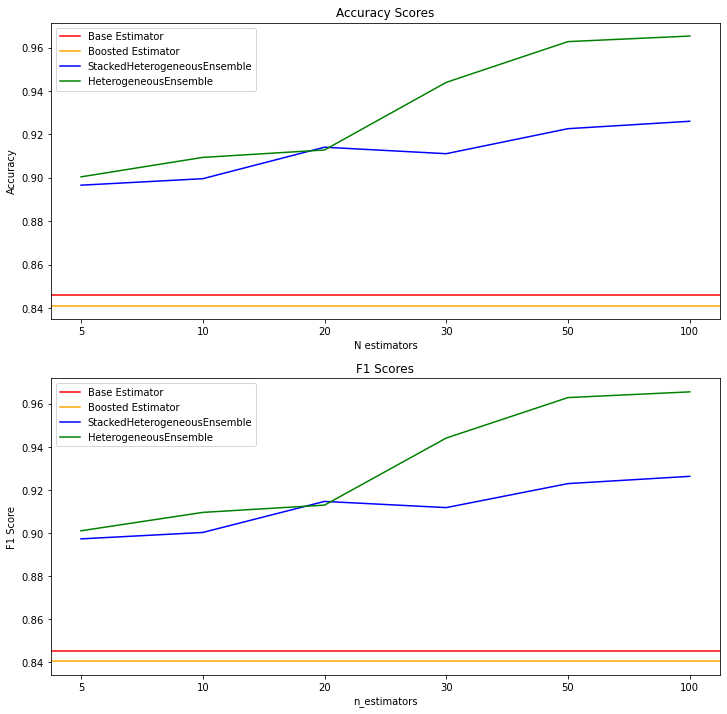

In [1070]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))
x = list(range(0,len(n_range)))
ax1.axhline(y=sv_base_acc, color='red', label='Base Estimator')
ax1.axhline(y=sv_boost_acc, color='orange', label='Boosted Estimator')
ax1.plot(x, sv_stack_acc, label="StackedHeterogeneousEnsemble", color="blue")
ax1.plot(x, sv_acc, label="HeterogeneousEnsemble", color="green")
ax1.legend(loc='upper left')
ax1.set_ylabel("Accuracy")
ax1.set_title("Accuracy Scores")
ax1.set_xticklabels([0] + n_range)
ax1.set_xlabel("N estimators")

ax2.axhline(y=sv_base_f1, color='red', label='Base Estimator')
ax2.axhline(y=sv_boost_f1, color='orange', label='Boosted Estimator')
ax2.plot(x, sv_stack_f1, label="StackedHeterogeneousEnsemble", color="blue")
ax2.plot(x, sv_f1, label="HeterogeneousEnsemble", color="green")
ax2.legend(loc='upper left')
ax2.set_ylabel("F1 Score")
ax2.set_xlabel("n_estimators")
ax2.set_xticklabels([0] + n_range)

f.set_xticklabels = n_range
ax2.set_title("F1 Scores")

We can see that accuracy does seem to increase as n_estimators increases for the heterogeneous ensemble, but for the stacked model it flattens out after 20. One possible reason for this is the curse of dimensionality. For n = 100, for instance, the stacked estimator will be receiving each query with (n * number_of_classes), in this case 1000 attributes per query. It does make me question the implementation of my stacked estimator.

I am curious if this drop off in accuracy will be visible no matter the base classifier for the stacked model. I decided to next investigate performance of differing base estimators for the stack. For a baseline, I will compare performance against the non-heterogeneous classifier. N will be set to 30, as that is where accuracy started to diverge in the previous experiment.

In [1105]:
clf = HeterogenousEnsembleClassifier(svm.SVC(random_state=0), hp_range_map=hparams['SVM'], n_estimators=30, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_valid)
base_acc_30 = accuracy_score(y_pred, y_valid)
clf = HeterogenousEnsembleClassifier(svm.SVC(random_state=0), hp_range_map=hparams['SVM'], n_estimators=10, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_valid)
base_acc_10 = accuracy_score(y_pred, y_valid)
acc = []
acc2 = []
for m in models:
    print(m)
    clf = StackedHeterogenousEnsembleClassifier(base_estimator=svm.SVC(random_state=42), hp_range_map=hparams['SVM'], n_estimators=30, random_state=0, stack_layer_estimator=copy(models[m]))
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    acc.append(accuracy_score(y_pred, y_valid))
    clf = StackedHeterogenousEnsembleClassifier(base_estimator=svm.SVC(random_state=42), hp_range_map=hparams['SVM'], n_estimators=10, random_state=0, stack_layer_estimator=copy(models[m]))
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    acc2.append(accuracy_score(y_pred, y_valid))



DTree
kNN
SVM
LR


Text(0.5, 0.98, 'Accuracy of Varying Classifiers for Stack')

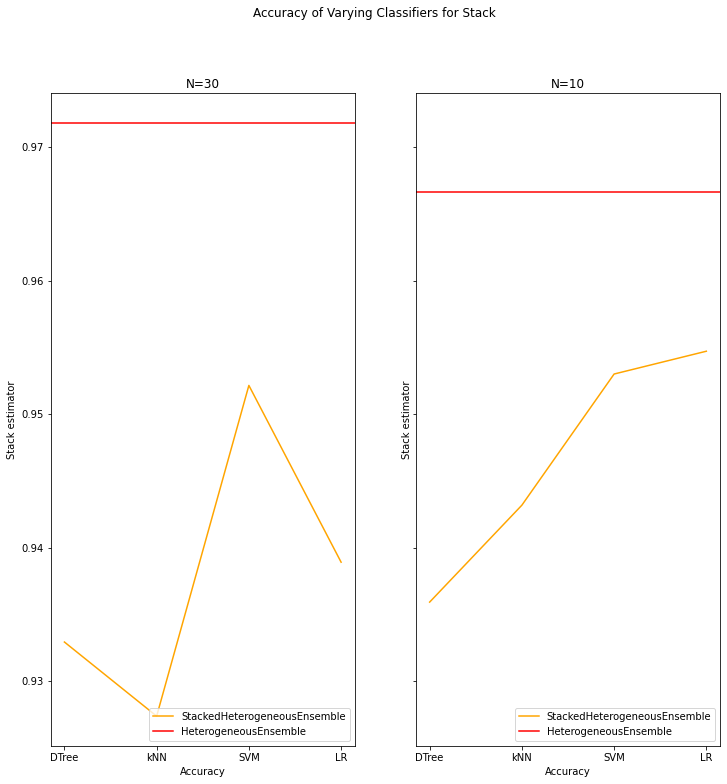

In [1106]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,12), sharey=True)
x = list(range(0,len(models)))
ax1.plot(x, acc, label="StackedHeterogeneousEnsemble", color="orange")
ax1.axhline(y=base_acc_30, color='red', label='HeterogeneousEnsemble')
ax1.legend(loc='lower right')
ax1.set_title("N=30")
ax1.set_xticks(list(range(0, len(models))))
ax1.set_xticklabels([m for m in models])
ax1.set_xlabel("Accuracy")
ax1.set_ylabel("Stack estimator")

ax2.plot(x, acc2, label="StackedHeterogeneousEnsemble", color="orange")
ax2.axhline(y=base_acc_10, color='red', label='HeterogeneousEnsemble')
ax2.legend(loc='lower right')
ax2.set_title("N=10")
ax2.set_xticks(list(range(0, len(models))))
ax2.set_xticklabels([m for m in models])
ax2.set_xlabel("Accuracy")
ax2.set_ylabel("Stack estimator")

f.suptitle("Accuracy of Varying Classifiers for Stack")

We are seeing pretty similar behaviour for n=10 and n=30. In all cases the stackedHeterogeneousEnsemble is underperforming, but performing best when using with logistic regression as the stack estimator. 

I am curious to see if varying the data ratio to the stack will effect performance. We will test a range of values, while keeping n=10.

In [1090]:
acc = []
ratio = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for r in ratio:
    print(r)
    clf = StackedHeterogenousEnsembleClassifier(base_estimator=svm.SVC(random_state=42), 
                                                hp_range_map=hparams['SVM'], n_estimators=10, 
                                                random_state=0, stack_layer_estimator=copy(models['LR']), 
                                                base_stack_data_ratio = r)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    acc.append(accuracy_score(y_pred, y_valid))




0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


Text(0, 0.5, 'base_stack_data_ratio')

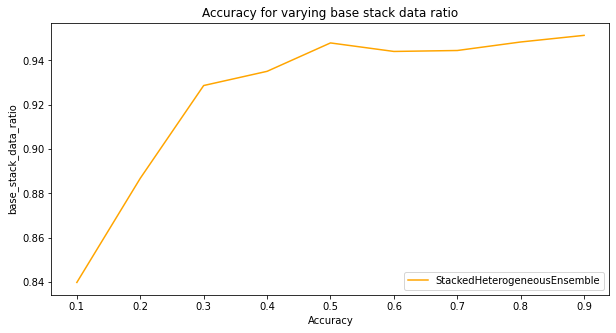

In [1096]:
f, ax1 = plt.subplots(1, 1, figsize=(10,5), sharex=True)
x = list(range(0,len(ratio)))
ax1.plot(x, acc, label="StackedHeterogeneousEnsemble", color="orange")
ax1.legend(loc='lower right')
ax1.set_title("Accuracy for varying base stack data ratio")
ax1.set_xticks(list(range(0, len(ratio))))
ax1.set_xticklabels(ratio)
ax1.set_xlabel("Accuracy")
ax1.set_ylabel("base_stack_data_ratio")

There are two peaks here, for ratio = 0.5, and ratio = 0.9. One imagines that a ratio of 0.9 would surely lead to underfitting of the stack estimator, I will cross validate to see if this holds.

In [1102]:
reps, folds = 5, 5
acc1,acc2, acc3 = [], [], []
for i in range (0, reps):
    kf = KFold(n_splits = folds, shuffle = True)
    clf1 = StackedHeterogenousEnsembleClassifier(base_estimator=svm.SVC(random_state=42), 
                                                hp_range_map=hparams['SVM'], n_estimators=10, 
                                                random_state=0, stack_layer_estimator=copy(models['LR']), 
                                                base_stack_data_ratio = .5)
    clf2 = StackedHeterogenousEnsembleClassifier(base_estimator=svm.SVC(random_state=42), 
                                                hp_range_map=hparams['SVM'], n_estimators=10, 
                                                random_state=0, stack_layer_estimator=copy(models['LR']), 
                                                base_stack_data_ratio = .7)
    clf3 = StackedHeterogenousEnsembleClassifier(base_estimator=svm.SVC(random_state=42), 
                                                hp_range_map=hparams['SVM'], n_estimators=10, 
                                                random_state=0, stack_layer_estimator=copy(models['LR']), 
                                                base_stack_data_ratio = .9)
    print("rep ", i+1)
    acc1.append(cross_val_score(clf1, X_train, y_train, cv=kf, scoring='accuracy', error_score="raise").mean())
    acc2.append(cross_val_score(clf2, X_train, y_train, cv=kf, scoring='accuracy', error_score="raise").mean())
    acc3.append(cross_val_score(clf3, X_train, y_train, cv=kf, scoring='accuracy', error_score="raise").mean())


rep  1
rep  2
rep  3
rep  4
rep  5


Text(0, 0.5, 'Folds')

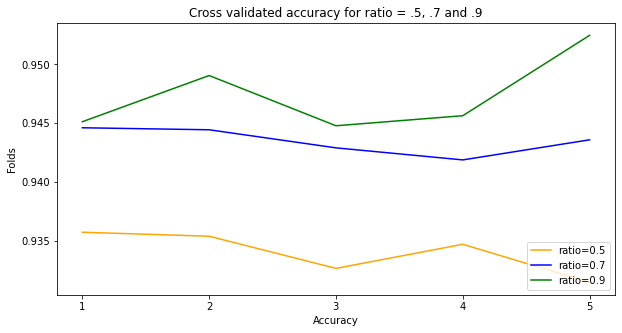

In [1103]:
f, ax1 = plt.subplots(1, 1, figsize=(10,5), sharex=True)
x = list(range(1,folds+1))
ax1.plot(x, acc1, label="ratio=0.5", color="orange")
ax1.plot(x, acc2, label="ratio=0.7", color="blue")
ax1.plot(x, acc3, label="ratio=0.9", color="green")
ax1.legend(loc='lower right')
ax1.set_title("Cross validated accuracy for ratio = .5, .7 and .9")
ax1.set_xticks(list(range(1, folds+1)))
ax1.set_xlabel("Accuracy")
ax1.set_ylabel("Folds")

In [ ]:
Interestingly, we can see that a ratio of .9 is consistently providing the highest accuracy. 

Given the knowledge garnered from the previous tests, I will now check performance on the test set. 
- For both the heterogeneous ensemble and the stacked ensemble I will use SVM as a base classifier.
- As accuracy seemed to increase as n increased for the heterogeneous ensemble, whereas it seemed to stagnate after n=20 for the stacked ensemble, I will set n=100 and n=20 respectively.
- For the stacked ensemble, I will set the data ratio to 0.9 and use logistic regression as the estimator for the stacked layer. 

In [1110]:
clf1 = StackedHeterogenousEnsembleClassifier(base_estimator=svm.SVC(random_state=42), 
                                                hp_range_map=hparams['SVM'], n_estimators=10, 
                                                random_state=0, stack_layer_estimator=copy(models['LR']), 
                                                base_stack_data_ratio = .9)
clf2 = HeterogenousEnsembleClassifier(base_estimator=svm.SVC(random_state=42), 
                                                hp_range_map=hparams['SVM'], n_estimators=100, 
                                                random_state=0)
clf3 = svm.SVC(random_state=i+i)
clf4 = BaggingClassifier(base_estimator=svm.SVC(random_state=i+i), random_state=i+i)
clfs = [clf1,clf2,clf3,clf4]

In [1111]:
results = []
for c in clfs:
    print(c.__class__.__name__)
    c.fit(X_train, y_train)
    results.append(accuracy_score(c.predict(X_test), y_test))

StackedHeterogenousEnsembleClassifier
HeterogenousEnsembleClassifier
SVC
BaggingClassifier


([<matplotlib.axis.XTick at 0x7fada19a81c0>,
 [Text(0.0, 0, 'StackedHeterogeneousEnsembleClassifier'),
  Text(0.1, 0, 'HeterogeneousEnsembleClassifier'),
  Text(0.2, 0, 'Single Classifier'),
  Text(0.3, 0, 'Bagged Classifier')])

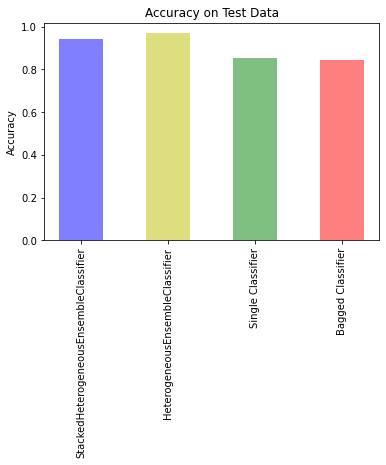

In [1124]:
X = np.arange(1)
plt.bar(X + 0.00, results[0], color = 'b', alpha=0.5, width = 0.05)
plt.bar(X + 0.10, results[1], color = 'y', alpha=0.5, width = 0.05)
plt.bar(X + 0.20, results[2], color = 'g', alpha=0.5, width = 0.05)
plt.bar(X + 0.30, results[3], color = 'r', alpha=0.5, width = 0.05)
plt.title("Accuracy on Test Data")
plt.ylabel("Accuracy")
plt.xticks(ticks=[0,0.1,0.2,0.3],
           rotation=90,
           labels=["StackedHeterogeneousEnsembleClassifier","HeterogeneousEnsembleClassifier","Single Classifier","Bagged Classifier"])

The classifiers have behaved just as we saw with the crossvalidated validation set. The Heterogeneous classifier has performed best, 
the stacked classifier is second, and the bagged and single classifier come in last.

### Perform Evaluation Experiment

-- First of all evaluate best classifier on the data with non stacked model

-- Then use the same base classifier with varying different stacked estimators

-- Then compare against 

## Task 4: Reflect on the Performance of the Different Models Evaluated

*Write your refelcection here (max 300 words)*